In [1]:
import os, re, string
import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import sklearn

from simpletransformers.classification import ClassificationModel
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter('ignore')

pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 2000)

In [2]:
model_type = 'distilbert'
model_name = 'distilbert-base-uncased'
with_kfold = False
weight = [0.44, 0.56]
n_splits = 1   # if with_kfold then must be n_splits > 1
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 96,
               'gradient_accumulation_steps': 2,
               'do_lower_case': True,
               'learning_rate': 1e-05,
               'overwrite_output_dir': True,
               'num_train_epochs': 2,
               'use_cuda': True,
               'cuda_device': 0}

In [3]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
train_data = pd.read_csv('work/datasets/twitter_disaster/train_data_clean.csv')[['text', 'target']]
test_data = pd.read_csv('work/datasets/twitter_disaster/test_data_clean.csv')[['text']]

Weights for 0 and 1: [0.44, 0.56]


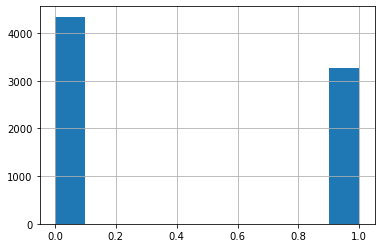

In [5]:
train_data['target'].hist()
print("Weights for 0 and 1:", weight)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3263 non-null   object
dtypes: object(1)
memory usage: 25.6+ KB


In [8]:
def subtext_repetition_in_df(df, col, subtext, num):
    # Calc statistics as table for character repetition (1...num times) from subtext list in the df[col]
    text = "".join(df[col])
    result = pd.DataFrame(columns = ['subtext', 'count'])
    i = 0
    if (len(df) > 0) and (len(subtext) > 0):
        for c in subtext:
            for j in range(num):
                cs = c*(j+1)
                result.loc[i,'count'] = text.count(cs)
                if c == ' ':
                    cs = cs.replace(' ','<space>')
                result.loc[i,'subtext'] = cs
                i += 1
    print('Number of all data is', len(df))
    result = result[result['count'] > 0].reset_index(drop=True)
    display(result.sort_values(by='subtext'))

    print('Text examples')
    problem_examples = pd.DataFrame(columns = ['problem_examples'])
    problem_examples['problem_examples'] = ''
    for i in range(len(result)):
        problem_examples.loc[i,'problem_examples'] = df[df[col].str.find(result.loc[i,'subtext'])>-1].reset_index(drop=True).loc[0, col]
    problem_examples = problem_examples.drop_duplicates()
    display(problem_examples)

In [9]:
# Analysis of punctuation marks repetition in training data
print('Statistics for punctuation marks repetition in training data')
subtext_repetition_in_df(train_data, 'text', list(string.punctuation), 10)

Statistics for punctuation marks repetition in training data
Number of all data is 7613


,subtext,count
0,!,905
1,#,3400
2,$,41
3,%,46
4,&,342
5,',1771
6,(,348
7,),362
8,*,144
9,+,67


Text examples


,problem_examples
0,What a goooooooaaaaaal !
1,Our Deeds are the Reason of this # earthquake May ALLAH Forgive us all
2,> > $ 15 Aftershock : Protect Yourself and Profit in the Next Global Financial . # book \n @ esquireattire
3,# Colorado # Avalanche Men ' s Official Colorado Avalanche Reebok T - Shirt XL Blue 100 % Cotton # NHL # Hockey
4,Rene Ablaze & Jacinta - Secret 2k13 ( Fallen Skies Edit ) - Mar 30 2013
5,All residents asked to ' shelter in place ' are being notified by officers . No other evacuation or shelter in place orders are expected
7,London is cool ; )
8,Aftershock was the most terrifying best roller coaster I have ever been on . * DISCLAIMER * I have been on very few .
9,+ Nicole Fletcher one of a victim of crashed airplane few times ago . \n\nThe accident left a little bit trauma for her . Although she is \n\n +
10,"13,000 people receive # wildfires evacuation orders in California"


In [10]:
# Analysis of punctuation marks repetition in test data
print('Statistics for punctuation marks repetition in test data')
subtext_repetition_in_df(test_data, 'text', list(string.punctuation), 10)

Statistics for punctuation marks repetition in test data
Number of all data is 3263


,subtext,count
0,!,388
1,#,1543
2,$,22
3,%,17
4,&,164
5,',769
6,(,156
7,),164
8,*,82
9,+,27


Text examples


,problem_examples
0,Hey ! How are you ?
1,"Heard about # earthquake is different cities, stay safe everyone ."
2,Why should a helicopter ambulance ride to transfer to a hospital 21 miles away cost $ 29800 ?
3,@ davej798 @ JohnEJefferson remind me when SomaliaEritrea & Nigeria were bombed by UK 28 % of asylum applicants to UK 2014 were from S & E
4,beware world ablaze sierra leone & guap .
5,"They ' d probably still show more life than Arsenal did yesterday, eh ? EH ?"
6,@ sakuma_en If you pretend to feel a certain way the feeling can become genuine all by accident . - Hei ( Darker than Black ) # manga # anime
8,* Latest Updates on the Salt River Wild Horse Round - up * via @ Change
9,Do people not understand they cant bleeding tweet everyone all the timedoes me head in ' stop ignoring me ' they are hardly ignoring you +
11,Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham ' s Wholesale Market


In [11]:
# Model training without KFold
if not with_kfold:
    model = ClassificationModel(model_type, model_name, args=model_args, weight=weight)
    model.train_model(train_data)
    result, model_outputs, wrong_predictions = model.eval_model(train_data, acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

  0%|          | 0/7613 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/80 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/952 [00:00<?, ?it/s]

In [12]:
if not with_kfold:
    y_preds, _, = model.predict(test_data['text'].values.tolist())
    pred_train, _ = model.predict(train_data['text'].values.tolist())

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

In [13]:
if not with_kfold:
    acc = result['acc']
    print('acc =',acc)

acc = 0.8087481938788914


In [14]:
# Model training with KFold
if with_kfold:
    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

    results = []
    wrong_predictions = []
    y_preds = np.zeros(test_data.shape[0])
    pred_train = np.zeros(train_data.shape[0])

    first_fold = True
    for train_index, val_index in kf.split(train_data):
        train_df = train_data.iloc[train_index]
        val_df = train_data.iloc[val_index]

        # Model training
        model = ClassificationModel(model_type, model_name, args=model_args)
        model.train_model(train_df)

        # Validation data prediction
        result, model_outputs_fold, wrong_predictions_fold = model.eval_model(val_df, acc=sklearn.metrics.accuracy_score)
        pred_train[val_index], _ = model.predict(val_df['text'].reset_index(drop=True))

        # Save fold results
        if first_fold:
            model_outputs = model_outputs_fold
            first_fold = False
        else: model_outputs = np.vstack((model_outputs,model_outputs_fold))

        wrong_predictions += wrong_predictions_fold
        results.append(result['acc'])

        # Test data prediction
        y_pred, _ = model.predict(test_data['text'])
        y_preds += y_pred / n_splits

In [15]:
# CV accuracy result output
if with_kfold:
    for i, result in enumerate(results, 1):
        print(f"Fold-{i}: {result}")

    acc = np.mean(results)

    print(f"{n_splits}-fold CV accuracy result: Mean: {acc} Standard deviation:{np.std(results)}")

In [16]:
y_preds[:] = y_preds[:]>=0.5
y_preds = y_preds.astype(int)
np.mean(y_preds)

0.41250383083052405

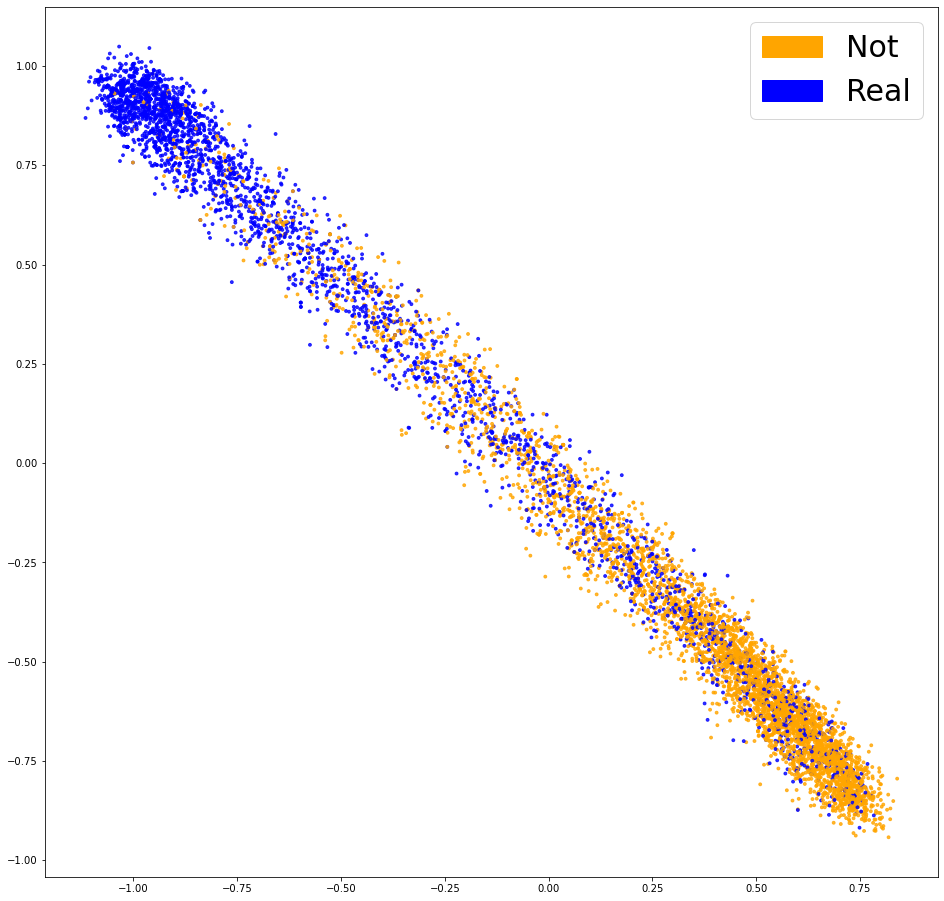

In [17]:
# Visualization of model outputs for each rows of training data
def plot_data_lavel(data, labels):
    colors = ['orange','blue']
    plt.scatter(data[:,0], data[:,1], s=8, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
    orange_patch = mpatches.Patch(color='orange', label='Not')
    blue_patch = mpatches.Patch(color='blue', label='Real')
    plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))
plot_data_lavel(model_outputs, train_data['target'].values)
plt.show()